### Experiments with training spectral bias

Imports

In [197]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse

Set save to True if you want to save plots

In [198]:
save = False

Only for python script: uncomment if running on cluster

In [199]:
# These are both placeholders
num_epochs = 100
model_name = None

In [200]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [201]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [202]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Base dataset class

In [203]:
class BaseFourierDataset(Dataset):
    def __init__(self, num_samples, num_points, max_freq):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_freq = max_freq
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.first_derivatives = self.generate_data()

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        n_terms = (len(c) - 1) // 2
        for n in range(-n_terms, n_terms+1):
            result += c[n + n_terms] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Can exclude the first element with the large derivative using [1:]
        # return torch.FloatTensor(self.functions[idx][1:]), torch.FloatTensor(self.first_derivatives[idx][1:])
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.first_derivatives[idx])

    def generate_data(self):
        raise NotImplementedError("Subclasses must implement generate_data method")

In [204]:
class LowFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=5):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

class HighFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, min_freq=15, max_freq=20):
        self.min_freq = min_freq
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            high_freq_coeffs = torch.complex(torch.randn(self.max_freq-self.min_freq+1), 
                                            torch.randn(self.max_freq-self.min_freq+1))
            c[self.max_freq+self.min_freq:] = high_freq_coeffs
            c[:self.max_freq-self.min_freq+1] = torch.conj(high_freq_coeffs.flip(0))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]

            functions.append(y.detach().numpy())
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)


In [205]:
class GeneralFrequencyFourierDataset(BaseFourierDataset):
    def __init__(self, num_samples, num_points, max_freq=random.randrange(20)):
        super().__init__(num_samples, num_points, max_freq)

    def generate_data(self):
        functions, first_derivatives = [], []

        for _ in range(self.num_samples):
            # Generate coefficients only for low frequencies (1 to max_freq)
            c = torch.zeros(2*self.max_freq+1, dtype=torch.complex64)
            c[self.max_freq-self.max_freq:self.max_freq+self.max_freq+1] = torch.complex(torch.randn(2*self.max_freq+1), torch.randn(2*self.max_freq+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            # y = y - y[0]  # Ensure f(0) = 0
            functions.append(y.detach().numpy())

            # Compute derivatives
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            first_derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(first_derivatives)

Uncomment the below to generate the datasets for the first time. After saving the datasets, they can be loaded in for future use.

In [206]:
num_samples = 500
num_points = 1000

# general_freq_dataset = GeneralFrequencyFourierDataset(num_samples, num_points)
# low_freq_dataset = LowFrequencyFourierDataset(num_samples, num_points, max_freq=5)
# high_freq_dataset = HighFrequencyFourierDataset(num_samples, num_points, min_freq=20, max_freq=30)

# # Create DataLoaders
# batch_size = 32
# general_dataloader = DataLoader(general_freq_dataset, batch_size=batch_size, shuffle=True)
# low_freq_dataloader = DataLoader(low_freq_dataset, batch_size=batch_size, shuffle=True)
# high_freq_dataloader = DataLoader(high_freq_dataset, batch_size=batch_size, shuffle=True)

# # Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

General frequency dataset

In [207]:
dataset_g = torch.load('../../datasets/general_freq_dataset.pt')
total_size = len(dataset_g)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_g, test_dataset_g = random_split(dataset_g, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

Low frequency dataset

In [208]:
dataset_l = torch.load('../../datasets/low_freq_dataset.pt')
total_size = len(dataset_l)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_l, test_dataset_l = random_split(dataset_l, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

High frequency dataset

In [209]:
dataset_h = torch.load('../../datasets/high_freq_dataset.pt')
total_size = len(dataset_h)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset_h, test_dataset_h = random_split(dataset_h, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)

## Plot a function

Low freq function

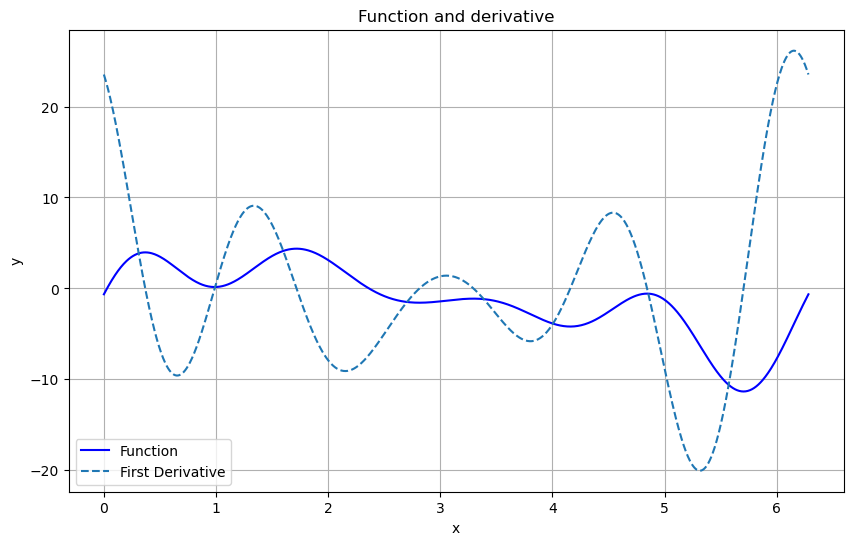

In [210]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='First Derivative', linestyle='--')
    
    plt.title('Function and derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(dataset=train_dataset_l, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

General freq function

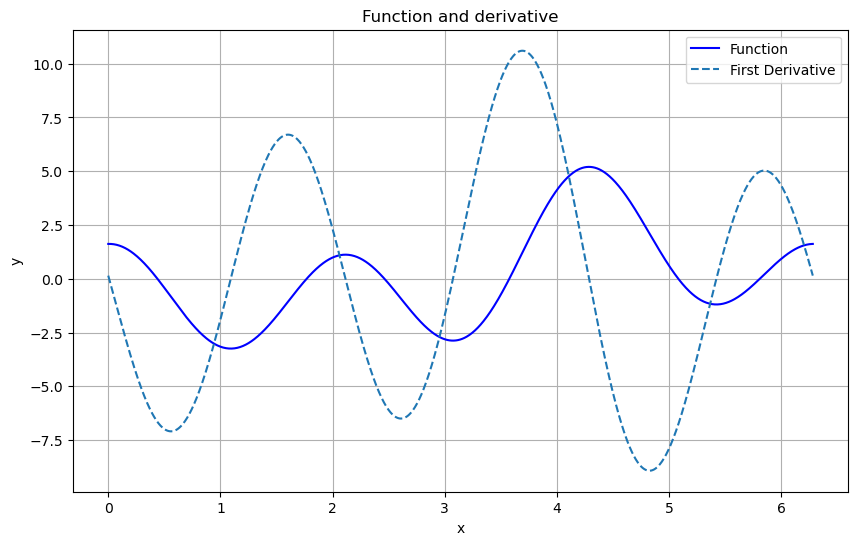

In [211]:
train_dataloader_viz = get_random_function(dataset=train_dataset_g, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

High freq function

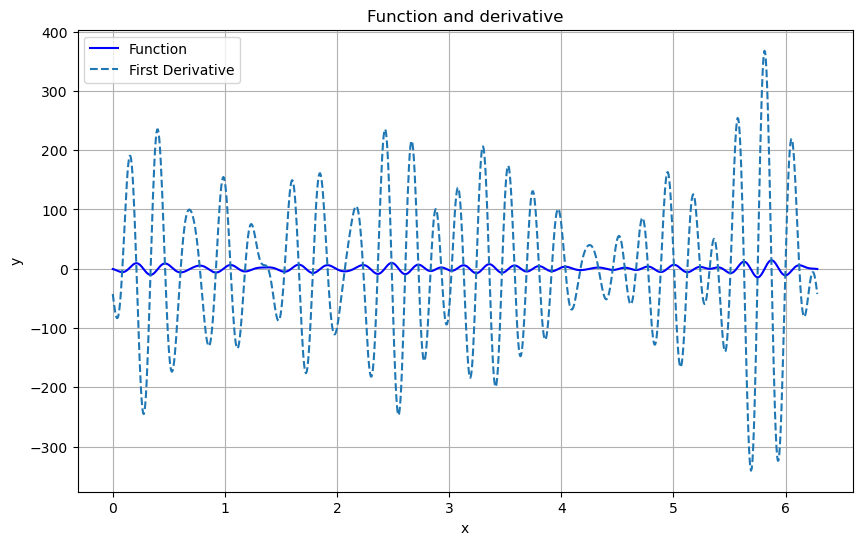

In [212]:
train_dataloader_viz = get_random_function(dataset=train_dataset_h, shuffle=True)
plot_function_and_derivative(train_dataloader_viz)

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [213]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [214]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

To use the previously trained model, uncomment below

In [215]:
# f0.load_state_dict(torch.load('models/f0_E1000_standardized.pth'))

## Miscellaneous plotting functions

In [216]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [217]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

## Plot results

Low frequency output

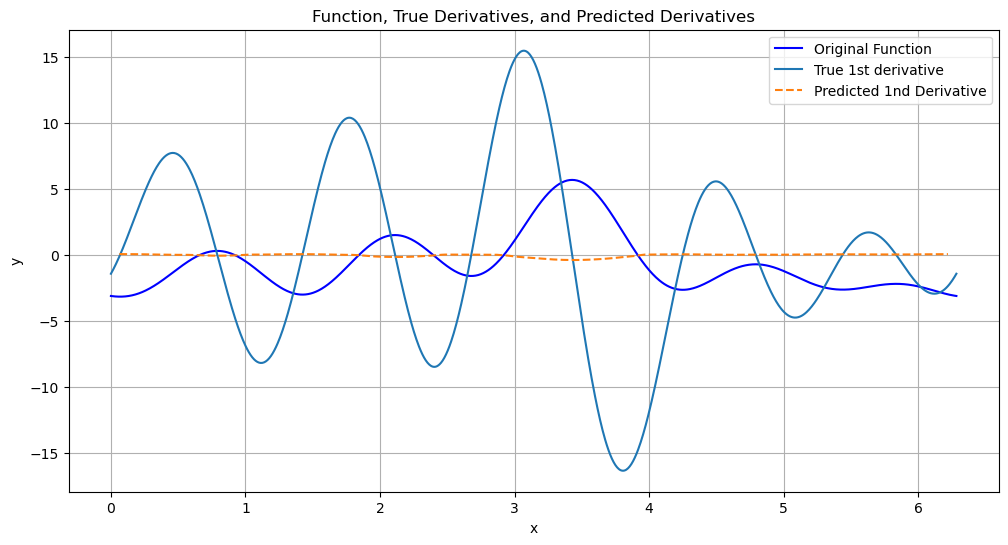

In [218]:
plot_output(f0, dataset=train_dataset_l, order=1, save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

General frequency output

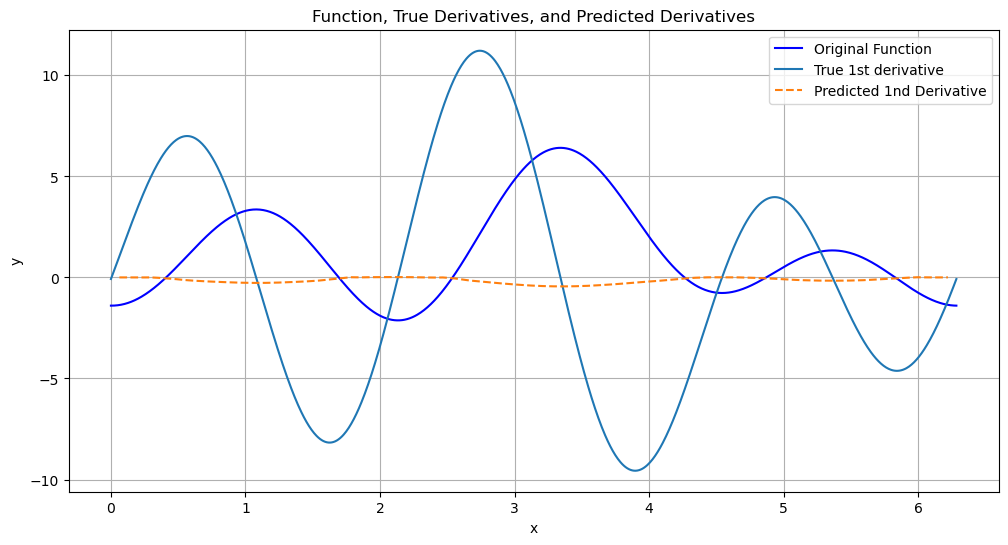

In [219]:
plot_output(f0, dataset=train_dataset_g, order=1, save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_gf_output', save=save)

High frequency output

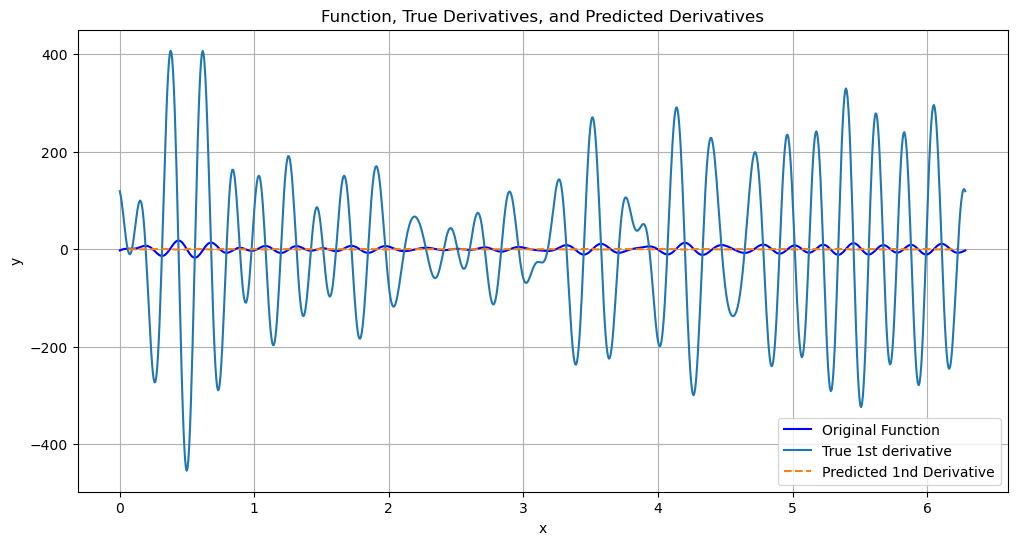

In [220]:
plot_output(f0, dataset=train_dataset_h, order=1, save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_hf_output', save=save)

## Metrics (MSE and NMSE)

In [221]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

Loss over low frequency functions

In [222]:
print(f"MSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[0]}")
print(f"NMSE over low freq train functions: {compute_mse(train_dataloader_l, f0)[1]}\n")

print(f"MSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[0]}")
print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, f0)[1]}")


MSE over low freq train functions: 112.37535095214844
NMSE over low freq train functions: 1.0002650022506714

MSE over low freq test functions: 117.25035095214844
NMSE over low freq test functions: 1.000205159187317


Loss over general frequency functions

In [223]:
print(f"MSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[0]}")
print(f"NMSE over general freq train functions: {compute_mse(train_dataloader_g, f0)[1]}\n")

print(f"MSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[0]}")
print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, f0)[1]}\n")

MSE over general freq train functions: 27.255739212036133
NMSE over general freq train functions: 1.0007922649383545

MSE over general freq test functions: 27.178239822387695
NMSE over general freq test functions: 1.0007846355438232



Loss over high frequency functions

In [224]:
print(f"MSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[0]}")
print(f"NMSE over high freq train functions: {compute_mse(train_dataloader_h, f0)[1]}\n")

print(f"MSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[0]}")
print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, f0)[1]}\n")

MSE over high freq train functions: 28146.224609375
NMSE over high freq train functions: 0.9999207854270935

MSE over high freq test functions: 27007.658203125
NMSE over high freq test functions: 0.9999188184738159



Function that includes all these print statements

In [225]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

### Model training

In [226]:
model1 = SimpleCNN()

In [227]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, order=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    plt.savefig(filename)  

    return train_losses, test_losses

Epoch [1/100], Train Loss: 27.2700, Test Loss: 26.6336
Epoch [2/100], Train Loss: 26.5095, Test Loss: 25.6473
Epoch [3/100], Train Loss: 25.3044, Test Loss: 23.7701
Epoch [4/100], Train Loss: 22.7063, Test Loss: 20.9261
Epoch [5/100], Train Loss: 19.4073, Test Loss: 16.9687
Epoch [6/100], Train Loss: 15.4635, Test Loss: 13.2751
Epoch [7/100], Train Loss: 12.1704, Test Loss: 10.1521
Epoch [8/100], Train Loss: 9.3807, Test Loss: 7.9339
Epoch [9/100], Train Loss: 7.4346, Test Loss: 6.2249
Epoch [10/100], Train Loss: 6.1914, Test Loss: 5.3516
Epoch [11/100], Train Loss: 5.4021, Test Loss: 4.5088
Epoch [12/100], Train Loss: 4.8128, Test Loss: 4.0675
Epoch [13/100], Train Loss: 4.2994, Test Loss: 3.6384
Epoch [14/100], Train Loss: 3.9021, Test Loss: 3.3195
Epoch [15/100], Train Loss: 3.5223, Test Loss: 2.9722
Epoch [16/100], Train Loss: 3.1868, Test Loss: 2.7150
Epoch [17/100], Train Loss: 2.9384, Test Loss: 2.4667
Epoch [18/100], Train Loss: 2.6455, Test Loss: 2.2461
Epoch [19/100], Train L

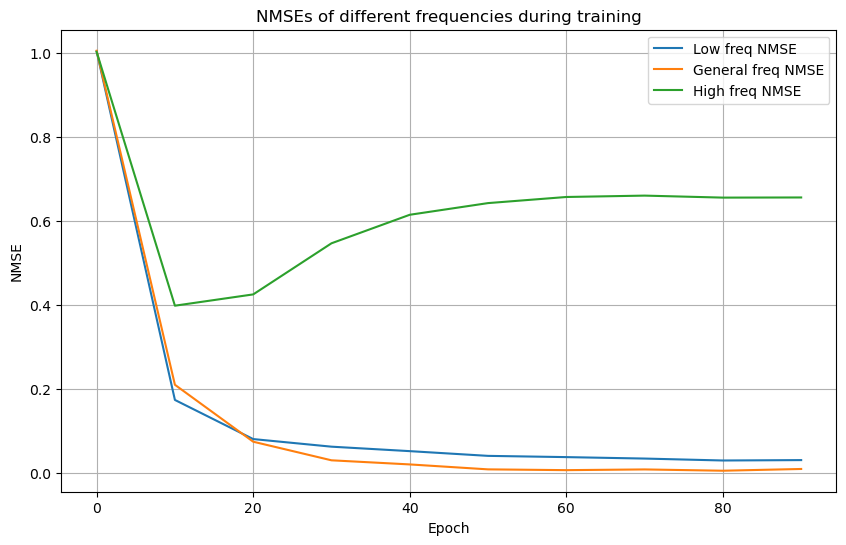

<Figure size 640x480 with 0 Axes>

In [228]:
train_losses, test_losses = model_training(model1, train_dataloader_g, test_dataloader_g,\
    num_epochs=100, split_freq=10, filename='plots/spectral_bias/f0_E1000_phased_training',\
    order='first')
torch.save(f0.state_dict(), f'../../models/{model_name}_E{num_epochs}_phased_training.pth')

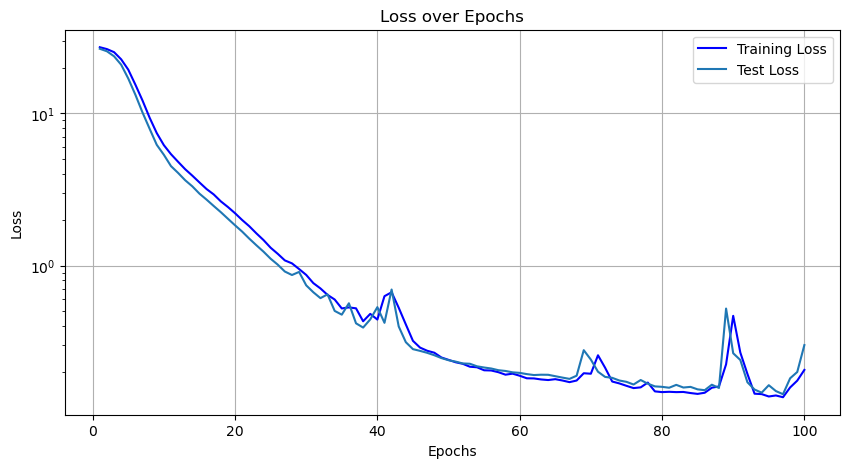

In [229]:
plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False)

## Training CNN with one layer

In [230]:
class OneLayerCNN(nn.Module):
    def __init__(self):
        super(OneLayerCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        return x

In [231]:
model2 = OneLayerCNN()

Epoch [1/1000], Train Loss: 27.4437, Test Loss: 27.2878
Epoch [2/1000], Train Loss: 27.4377, Test Loss: 27.1967
Epoch [3/1000], Train Loss: 27.0309, Test Loss: 27.1260
Epoch [4/1000], Train Loss: 26.7058, Test Loss: 27.0734
Epoch [5/1000], Train Loss: 27.1122, Test Loss: 27.0362
Epoch [6/1000], Train Loss: 26.8969, Test Loss: 27.0112
Epoch [7/1000], Train Loss: 27.1718, Test Loss: 26.9947
Epoch [8/1000], Train Loss: 27.2131, Test Loss: 26.9842
Epoch [9/1000], Train Loss: 27.1851, Test Loss: 26.9774
Epoch [10/1000], Train Loss: 27.3366, Test Loss: 26.9730
Epoch [11/1000], Train Loss: 27.2168, Test Loss: 26.9698
Epoch [12/1000], Train Loss: 26.9832, Test Loss: 26.9674
Epoch [13/1000], Train Loss: 27.0143, Test Loss: 26.9652
Epoch [14/1000], Train Loss: 27.2449, Test Loss: 26.9631
Epoch [15/1000], Train Loss: 27.1580, Test Loss: 26.9611
Epoch [16/1000], Train Loss: 27.1547, Test Loss: 26.9591
Epoch [17/1000], Train Loss: 26.8789, Test Loss: 26.9570
Epoch [18/1000], Train Loss: 26.9327, Te

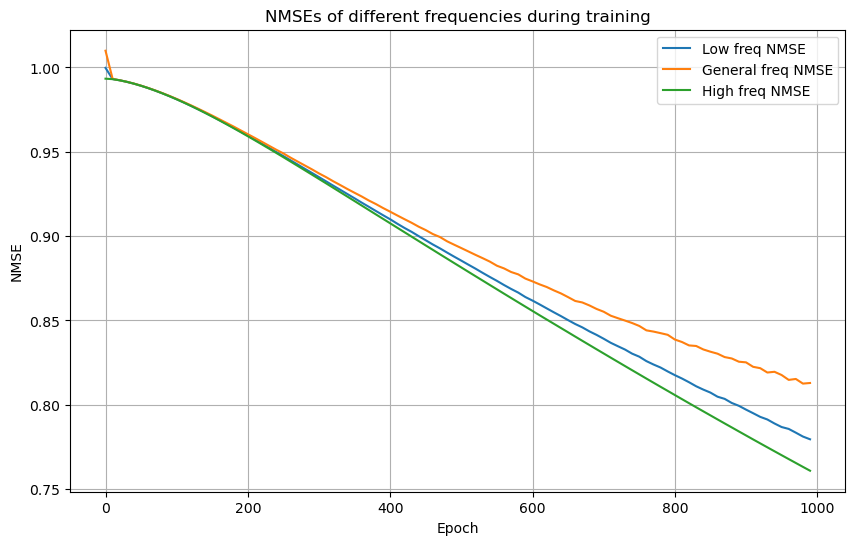

<Figure size 640x480 with 0 Axes>

In [232]:
train_losses, test_losses = model_training(model2, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='plots/spectral_bias/f0_E1000_one_layer',\
        order='first')

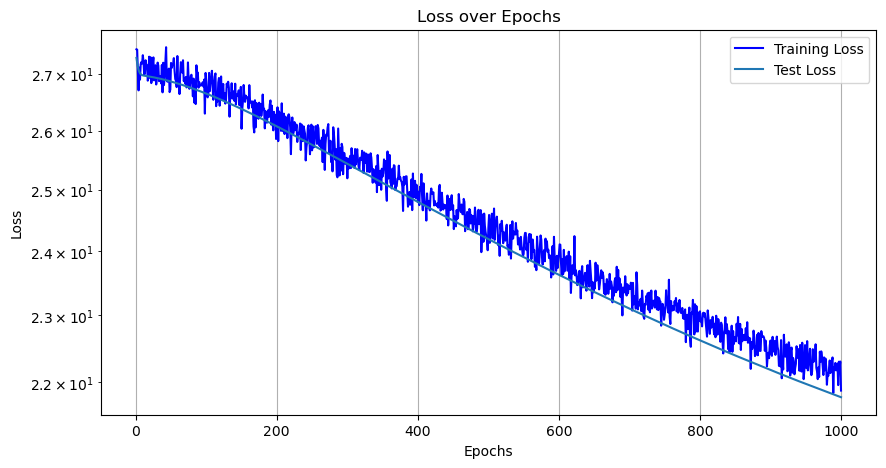

In [233]:
plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False)

## Plot results using trained models

3-layer conv

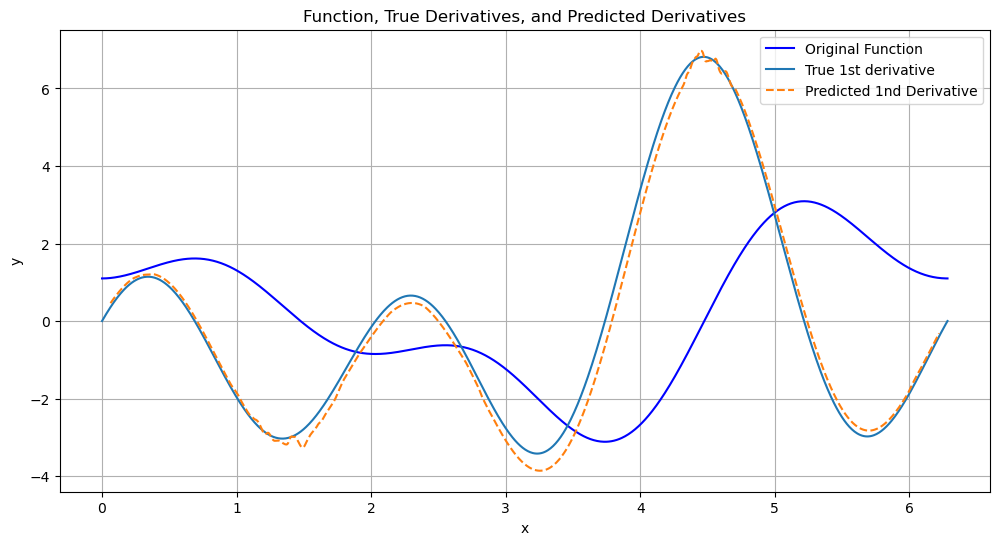

In [234]:
plot_output(model1, dataset=train_dataset_g, order=1, save_dir='plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_gf_output', save=save)

One-layer conv

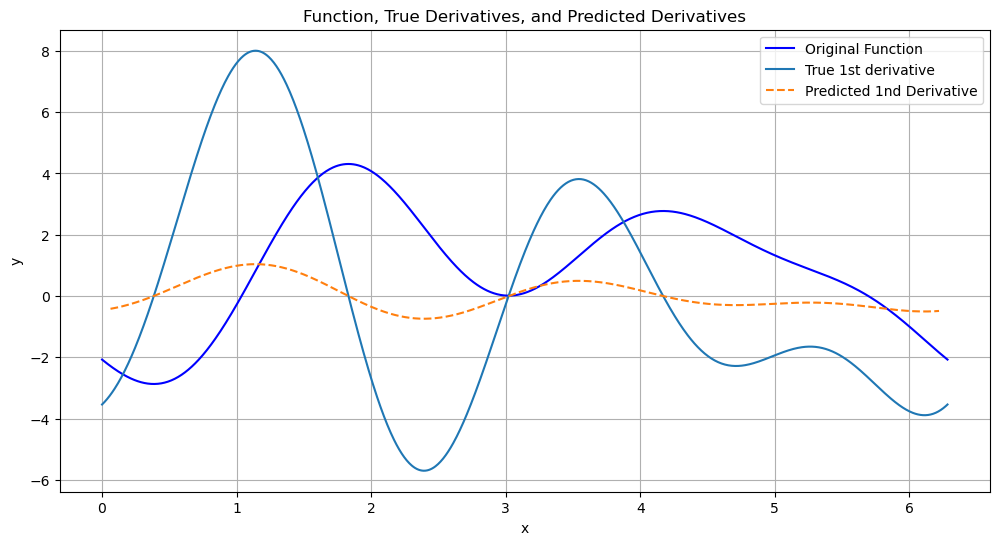

In [235]:
plot_output(model2, dataset=train_dataset_g, order=1,\
    save_dir='plots/spectral_bias',\
        filename=f'{model_name}_E{num_epochs}_one_layer_output', save=save)